In [1]:
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import keras
import tensorflow as tf
import helpers as hp
import pickle
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Input, Lambda, Dense, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras import optimizers
from keras.utils import to_categorical
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
print("Number of GPUs available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6881568512776038017
]
Number of GPUs available:  0



In [2]:
load_dir = 1
load_mod = 1
extract = 1

source_cov = hp.source_cov
source_pne = hp.source_pne
source_hea = hp.source_hea

# set to image directory
cov = glob.glob(source_cov+'*')
pne = glob.glob(source_pne+'*')
hea = glob.glob(source_hea+'*')

# parameters
cov_train_num = hp.cov_train_num
pne_train_num = hp.pne_train_num
hea_train_num = hp.hea_train_num

# select random subset of images for training
if load_dir:
	with open('directory.pkl','rb') as f:
		cov_train, pne_train = pickle.load(f)
	cov_train = [source_cov+img.split(os.sep)[-1] for img in cov_train]
	pne_train = [source_pne+img.split(os.sep)[-1] for img in pne_train]
else:
	cov_train = np.random.choice(cov,size=cov_train_num,replace=False)
	pne_train = np.random.choice(pne,size=pne_train_num,replace=False)
	with open('directory.pkl','wb') as f:
		pickle.dump([cov_train, pne_train],f)

hea_train = np.random.choice(hea,size=hea_train_num,replace=False)
cov_test = list(set(cov)-set(cov_train))
pne_test = list(set(pne)-set(pne_train))
hea_test = list(set(hea)-set(hea_train))

cov_test_num = len(cov_test)
pne_test_num = len(pne_test)
hea_test_num = len(hea_test)

print('Model 1: COVID vs. pneumonia:')
print('     COVID training set size: '+str(cov_train_num))
print('     Pneumonia training set size: '+str(pne_train_num))
print('     Total training set size: '+str(cov_train_num+pne_train_num))
print()
print('     COVID testing set size: '+str(cov_test_num))
print('     Pneumonia testing set size: '+str(pne_test_num))
print('     Total testing set size: '+str(cov_test_num+pne_test_num))
print('Model 2: COVID vs. healthy:')
print('     COVID training set size: '+str(cov_train_num))
print('     Healthy training set size: '+str(hea_train_num))
print('     Total training set size: '+str(cov_train_num+hea_train_num))
print()
print('     COVID testing set size: '+str(cov_test_num))
print('     Healthy testing set size: '+str(hea_test_num))
print('     Total testing set size: '+str(cov_test_num+hea_test_num))
print()

IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_DIM = (IMG_WIDTH,IMG_HEIGHT)

# load training images and create corresponding labels
cov_train_imgs = [img_to_array(load_img(img,target_size=IMG_DIM,color_mode="rgb")) for img in cov_train]
pne_train_imgs = [img_to_array(load_img(img,target_size=IMG_DIM,color_mode="rgb")) for img in pne_train]
hea_train_imgs = [img_to_array(load_img(img,target_size=IMG_DIM,color_mode="rgb")) for img in hea_train]

mod1_train_imgs = np.array(cov_train_imgs+pne_train_imgs)
mod1_train_imgs = mod1_train_imgs.astype('float32')/255
mod1_train_labels = np.array(cov_train_num*[1]+pne_train_num*[0])
mod1_train_labels = to_categorical(mod1_train_labels)
mod2_train_imgs = np.array(cov_train_imgs+hea_train_imgs)
mod2_train_imgs = mod2_train_imgs.astype('float32')/255
mod2_train_labels = np.array(cov_train_num*[1]+hea_train_num*[0])
mod2_train_labels = to_categorical(mod2_train_labels)

# load test images and create corresponding labels
cov_test_imgs = [img_to_array(load_img(img,target_size=IMG_DIM,color_mode="rgb")) for img in cov_test]
pne_test_imgs = [img_to_array(load_img(img,target_size=IMG_DIM,color_mode="rgb")) for img in pne_test]
hea_test_imgs = [img_to_array(load_img(img,target_size=IMG_DIM,color_mode="rgb")) for img in hea_test]

mod1_test_imgs = np.array(cov_test_imgs+pne_test_imgs)
mod1_test_imgs = mod1_test_imgs.astype('float32')/255
mod1_test_labels = np.array(cov_test_num*[1]+pne_test_num*[0])
mod1_test_labels = to_categorical(mod1_test_labels)
mod2_test_imgs = np.array(cov_test_imgs+hea_test_imgs)
mod2_test_imgs = mod2_test_imgs.astype('float32')/255
mod2_test_labels = np.array(cov_test_num*[1]+hea_test_num*[0])
mod2_test_labels = to_categorical(mod2_test_labels)

Model 1: COVID vs. pneumonia:
     COVID training set size: 90
     Pneumonia training set size: 90
     Total training set size: 180

     COVID testing set size: 32
     Pneumonia testing set size: 206
     Total testing set size: 238
Model 2: COVID vs. healthy:
     COVID training set size: 90
     Healthy training set size: 90
     Total training set size: 180

     COVID testing set size: 32
     Healthy testing set size: 726
     Total testing set size: 758



In [3]:
# create traditional classifier
input_shape = (IMG_HEIGHT,IMG_WIDTH,mod1_train_imgs.shape[3])
base_network = hp.vggnet_base(input_shape)
x = base_network.output
x = BatchNormalization()(x)
x = Dense(2, activation='softmax')(x)
vgg_mod1 = Model(base_network.input,x)
vgg_mod2 = Model(base_network.input,x)
for layer in vgg_mod1.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x154a49b90> False
<keras.layers.convolutional.Conv2D object at 0x103685750> False
<keras.layers.convolutional.Conv2D object at 0x10367af50> False
<keras.layers.pooling.MaxPooling2D object at 0x15490ad50> False
<keras.layers.convolutional.Conv2D object at 0x15490a7d0> False
<keras.layers.convolutional.Conv2D object at 0x154a9ff90> False
<keras.layers.pooling.MaxPooling2D object at 0x1929c9390> False
<keras.layers.convolutional.Conv2D object at 0x1929dd990> False
<keras.layers.convolutional.Conv2D object at 0x1929dfc90> False
<keras.layers.convolutional.Conv2D object at 0x1929df850> False
<keras.layers.pooling.MaxPooling2D object at 0x1929f6bd0> False
<keras.layers.convolutional.Conv2D object at 0x194946d10> False
<keras.layers.convolutional.Conv2D object at 0x194956ed0> False
<keras.layers.convolutional.Conv2D object at 0x194946ed0> False
<keras.layers.pooling.MaxPooling2D object at 0x194969150> False
<keras.layers.convolutional.Conv2D obj

In [4]:
# train or load model
generator = 1
batch_size = 10
adm = optimizers.Adam(lr=1e-5)
if load_mod:
    vgg_mod1 = load_model('mod1_tr180_ep25_g1.h5',compile=False)
    vgg_mod1.compile(loss='categorical_crossentropy', optimizer=adm, metrics=['accuracy'])
    vgg_mod1.summary()
    vgg_mod2 = load_model('mod2_tr180_ep25_g1.h5',compile=False)
    vgg_mod2.compile(loss='categorical_crossentropy', optimizer=adm, metrics=['accuracy'])
    vgg_mod2.summary()
else:
    epochs = 25
    vgg_mod1.compile(loss='categorical_crossentropy', optimizer=adm, metrics=['accuracy'])
    vgg_mod1.summary()
    if generator:
        vgg_mod1.fit_generator(hp.datagen.flow(mod1_train_imgs,mod1_train_labels,batch_size=batch_size), 
                            steps_per_epoch=np.ceil(mod1_train_imgs.shape[0]/batch_size),
                            epochs=epochs,
                            validation_data=(mod1_test_imgs[:100],mod1_test_labels[:100]),
                            shuffle=True,
                            verbose=1)
    else:
        vgg_mod1.fit(mod1_train_imgs,mod1_train_labels,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(mod1_test_imgs[:100],mod1_test_labels[:100]),
            shuffle=True)
    vgg_mod1.save('mod1_tr'+str(mod1_train_imgs.shape[0])+'_ep'+str(epochs)+'_g'+str(generator)+'.h5')

    vgg_mod2.compile(loss='categorical_crossentropy', optimizer=adm, metrics=['accuracy'])
    vgg_mod2.summary()
    if generator:
        vgg_mod2.fit_generator(hp.datagen.flow(mod2_train_imgs,mod2_train_labels,batch_size=batch_size), 
                            steps_per_epoch=np.ceil(mod2_train_imgs.shape[0]/batch_size),
                            epochs=epochs,
                            validation_data=(mod2_test_imgs[:100],mod2_test_labels[:100]),
                            shuffle=True,
                            verbose=1)
    else:
        vgg_mod2.fit(mod2_train_imgs,mod2_train_labels,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(mod2_test_imgs[:100],mod2_test_labels[:100]),
            shuffle=True)
    vgg_mod1.save('mod2_tr'+str(mod2_train_imgs.shape[0])+'_ep'+str(epochs)+'_g'+str(generator)+'.h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [5]:
mod1_train_labels_pred = vgg_mod1.predict(mod1_train_imgs)
mod1_train_acc = np.mean(np.argmax(mod1_train_labels,axis=1)==np.argmax(mod1_train_labels_pred,axis=1))
mod1_test_labels_pred = vgg_mod1.predict(mod1_test_imgs)
mod1_test_acc = np.mean(np.argmax(mod1_test_labels,axis=1)==np.argmax(mod1_test_labels_pred,axis=1))
tp,tn,fp,fn,sensitivity,specificity = hp.generate_metrics(np.argmax(mod1_test_labels,axis=1),np.argmax(mod1_test_labels_pred,axis=1))

print('Model 1, COVID vs. pneumonia:')
print('     Accuracy on training set: %0.2f%%' % (100 * mod1_train_acc))
print('     Accuracy on test set: %0.2f%%' % (100 * mod1_test_acc))
print()
print('     True positives: '+str(tp))
print('     True negatives: '+str(tn))
print('     False positives: '+str(fp))
print('     False negatives: '+str(fn))
print('     Sensitivity: '+str(sensitivity))
print('     Specificity: '+str(specificity))

mod2_train_labels_pred = vgg_mod2.predict(mod2_train_imgs)
mod2_train_acc = np.mean(np.argmax(mod2_train_labels,axis=1)==np.argmax(mod2_train_labels_pred,axis=1))
mod2_test_labels_pred = vgg_mod2.predict(mod2_test_imgs)
mod2_test_acc = np.mean(np.argmax(mod2_test_labels,axis=1)==np.argmax(mod2_test_labels_pred,axis=1))
tp,tn,fp,fn,sensitivity,specificity = hp.generate_metrics(np.argmax(mod2_test_labels,axis=1),np.argmax(mod2_test_labels_pred,axis=1))

print('Model 2, COVID vs. healthy:')
print('     Accuracy on training set: %0.2f%%' % (100 * mod2_train_acc))
print('     Accuracy on test set: %0.2f%%' % (100 * mod2_test_acc))
print()
print('     True positives: '+str(tp))
print('     True negatives: '+str(tn))
print('     False positives: '+str(fp))
print('     False negatives: '+str(fn))
print('     Sensitivity: '+str(sensitivity))
print('     Specificity: '+str(specificity))

Model 1, COVID vs. pneumonia:
     Accuracy on training set: 96.67%
     Accuracy on test set: 89.92%

     True positives: 27.0
     True negatives: 187.0
     False positives: 19.0
     False negatives: 5.0
     Sensitivity: 0.84375
     Specificity: 0.9077669902912622
Model 2, COVID vs. healthy:
     Accuracy on training set: 97.22%
     Accuracy on test set: 98.02%

     True positives: 26.0
     True negatives: 717.0
     False positives: 9.0
     False negatives: 6.0
     Sensitivity: 0.8125
     Specificity: 0.987603305785124


COVID test image index: 31
Pneumonia test image index: 6
Healthy test image index: 79


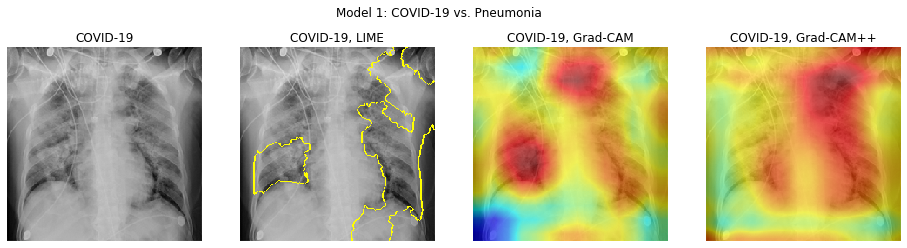

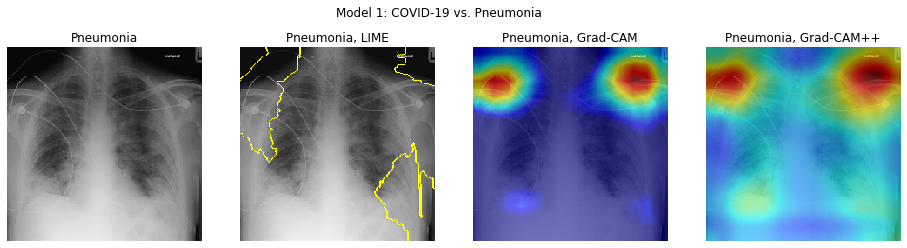

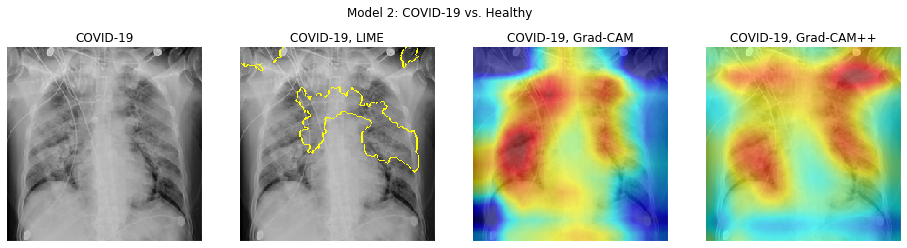

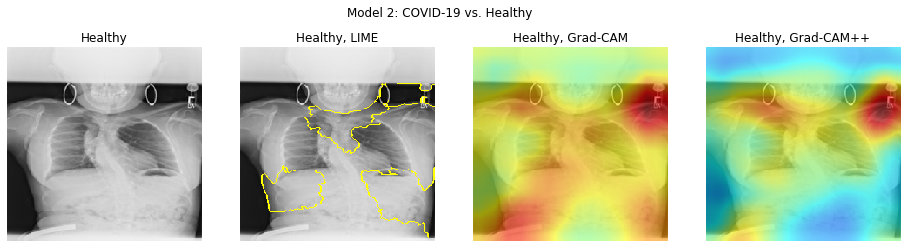

In [6]:
if extract:
    # find pictures classified with highest probabilities
    idx_cov = np.argmax(mod1_test_labels_pred[:cov_train_num,1])
    idx_pne = np.argmax(mod1_test_labels_pred[cov_train_num:,0])
    idx_hea = np.argmax(mod2_test_labels_pred[cov_train_num:,0])
    print('COVID test image index: '+str(idx_cov))
    print('Pneumonia test image index: '+str(idx_pne))
    print('Healthy test image index: '+str(idx_hea))

    img_cov = np.expand_dims(np.array(cov_test_imgs[idx_cov]).astype('float32')/255,axis=0)
    img_pne = np.expand_dims(np.array(pne_test_imgs[idx_pne]).astype('float32')/255,axis=0)
    img_hea = np.expand_dims(np.array(hea_test_imgs[idx_hea]).astype('float32')/255,axis=0)

    mod1_cov_lime, mod1_cov_gradcam, mod1_cov_gradcamplus = hp.extract_features(vgg_mod1,img_cov,'mod1_cov')
    mod1_pne_lime, mod1_pne_gradcam, mod1_pne_gradcamplus = hp.extract_features(vgg_mod1,img_pne,'mod1_pne')
    mod2_cov_lime, mod2_cov_gradcam, mod2_cov_gradcamplus = hp.extract_features(vgg_mod2,img_cov,'mod2_cov')
    mod2_hea_lime, mod2_hea_gradcam, mod2_hea_gradcamplus = hp.extract_features(vgg_mod2,img_hea,'mod2_hea')

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(16,4))
    fig.suptitle('Model 1: COVID-19 vs. Pneumonia')
    ax1.imshow(img_cov[0])
    ax1.set_title('COVID-19')
    ax1.axis('off')
    ax2.imshow(mod1_cov_lime)
    ax2.set_title('COVID-19, LIME')
    ax2.axis('off')
    ax3.imshow(mod1_cov_gradcam)
    ax3.set_title('COVID-19, Grad-CAM')
    ax3.axis('off')
    ax4.imshow(mod1_cov_gradcamplus)
    ax4.set_title('COVID-19, Grad-CAM++')
    ax4.axis('off')
    plt.show()
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(16,4))
    fig.suptitle('Model 1: COVID-19 vs. Pneumonia')
    ax1.imshow(img_pne[0])
    ax1.set_title('Pneumonia')
    ax1.axis('off')
    ax2.imshow(mod1_pne_lime)
    ax2.set_title('Pneumonia, LIME')
    ax2.axis('off')
    ax3.imshow(mod1_pne_gradcam)
    ax3.set_title('Pneumonia, Grad-CAM')
    ax3.axis('off')
    ax4.imshow(mod1_pne_gradcamplus)
    ax4.set_title('Pneumonia, Grad-CAM++')
    ax4.axis('off')
    plt.show()
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(16,4))
    fig.suptitle('Model 2: COVID-19 vs. Healthy')
    ax1.imshow(img_cov[0])
    ax1.set_title('COVID-19')
    ax1.axis('off')
    ax2.imshow(mod2_cov_lime)
    ax2.set_title('COVID-19, LIME')
    ax2.axis('off')
    ax3.imshow(mod2_cov_gradcam)
    ax3.set_title('COVID-19, Grad-CAM')
    ax3.axis('off')
    ax4.imshow(mod2_cov_gradcamplus)
    ax4.set_title('COVID-19, Grad-CAM++')
    ax4.axis('off')
    plt.show()
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(16,4))
    fig.suptitle('Model 2: COVID-19 vs. Healthy')
    ax1.imshow(img_hea[0])
    ax1.set_title('Healthy')
    ax1.axis('off')
    ax2.imshow(mod2_hea_lime)
    ax2.set_title('Healthy, LIME')
    ax2.axis('off')
    ax3.imshow(mod2_hea_gradcam)
    ax3.set_title('Healthy, Grad-CAM')
    ax3.axis('off')
    ax4.imshow(mod2_hea_gradcamplus)
    ax4.set_title('Healthy, Grad-CAM++')
    ax4.axis('off')
    plt.show()